<a href="https://colab.research.google.com/github/Venura-Shiromal/NASA-Space-Apps-2025/blob/main/KOI/KOI_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisities

In [1]:
### If hasn't installed already
# !pip install pandas
# !pip install catboost
# !pip install sklearn
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [21]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

In [22]:
koi = pd.read_csv('KOI_Data.csv', comment='#')

## Feature Selection

In [23]:
features = [
    # Orbital / Transit properties
    "koi_period",        # Orbital Period [days]
    "koi_time0bk",       # Transit Epoch [BKJD]
    "koi_impact",        # Impact Parameter
    "koi_duration",      # Transit Duration [hrs]
    "koi_depth",         # Transit Depth [ppm]
    "koi_model_snr",     # Transit Signal-to-Noise Ratio

    # Stellar properties
    "koi_steff",         # Stellar Effective Temperature [K]
    "koi_slogg",         # Stellar Surface Gravity [log10(cm/s**2)]
    "koi_srad",          # Stellar Radius [Solar radii]
    "koi_kepmag",         # Kepler Magnitude

    "koi_pdisposition"   # Disposition
]

### Selecting Features

In [24]:
koi = koi[features]

## Label Mapping

In [25]:
label_map = {
    "FALSE POSITIVE" : 0,
    "CANDIDATE" : 1
  }

koi["koi_pdisposition"] = koi["koi_pdisposition"].map(label_map)

### Filling empty cells

In [26]:
koi = koi.fillna(koi.mean())

### Diagnoise if want

In [27]:
#print(koi.shape[0])
#print(koi["koi_pdisposition"].unique())
#print(koi.dtypes)
#np.isnan(koi).sum()
#koi.head()
#print(koi.isna().sum()[koi.isna().sum() > 957])
#for col in features:
#    print(koi[col].dtype)

# Defining data sets

In [28]:
X = koi.drop("koi_pdisposition", axis=1)
y = koi["koi_pdisposition"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

## Defining Classes

In [30]:
classes = np.unique(y_train)

## Calculating Class Weights

In [31]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

### Combining both

In [32]:
class_weights = dict(zip(classes, weights))

## Cross-validation

In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

# Cat Boost Initiation

## Parameters


In [34]:
model = CatBoostClassifier(
    iterations=2500,
    depth=8,
    learning_rate=0.06,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=5,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)

# Training

In [35]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.6720380	test: 0.6711012	best: 0.6711012 (0)	total: 29.9ms	remaining: 1m 14s
50:	learn: 0.3853080	test: 0.3711278	best: 0.3711278 (50)	total: 1.05s	remaining: 50.6s
100:	learn: 0.3410592	test: 0.3285225	best: 0.3285225 (100)	total: 2.62s	remaining: 1m 2s
150:	learn: 0.3163900	test: 0.3056152	best: 0.3056152 (150)	total: 4.35s	remaining: 1m 7s
200:	learn: 0.2980758	test: 0.2896674	best: 0.2896674 (200)	total: 5.36s	remaining: 1m 1s
250:	learn: 0.2813900	test: 0.2759243	best: 0.2759243 (250)	total: 6.37s	remaining: 57.1s
300:	learn: 0.2676941	test: 0.2654762	best: 0.2654762 (300)	total: 7.38s	remaining: 53.9s
350:	learn: 0.2552730	test: 0.2552548	best: 0.2552548 (350)	total: 8.38s	remaining: 51.3s
400:	learn: 0.2438924	test: 0.2462418	best: 0.2462418 (400)	total: 9.39s	remaining: 49.2s
450:	learn: 0.2338116	test: 0.2387081	best: 0.2387081 (450)	total: 10.4s	remaining: 47.3s
500:	learn: 0.2240145	test: 0.2311061	best: 0.2311061 (500)	total: 11.4s	remaining: 45.6s
550:	learn: 0.

## Plotting Loss

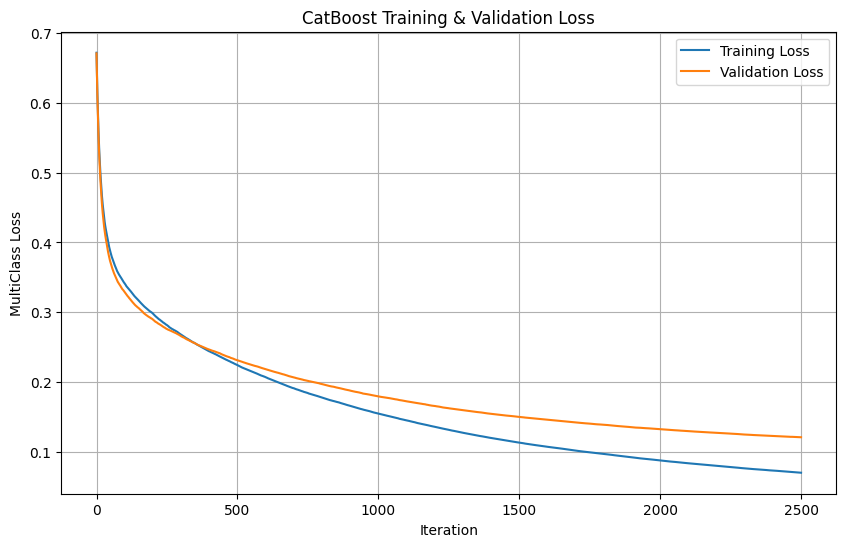

In [37]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [38]:
y_pred = model.predict(X_test)

## Confusion Matrix

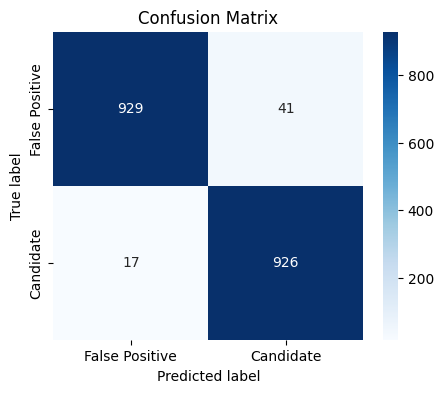

In [39]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["False Positive", "Candidate"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## Accuracy

In [40]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.2f}%".format(acc * 100))
print("Precision Score: {:.2f}%".format(precision * 100))
print("Recall Score: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Accuracy: 96.97%
Precision Score: 97.00%
Recall Score: 96.97%
F1 Score: 96.97%


# Saving Model

In [41]:
model.save_model("koi_model.onnx", format="onnx")